# Exoplanet Detection using Neural Networks

## Introduction

In [1]:
from lightkurve.correctors import CBVCorrector
from tqdm import tqdm
from torch import nn
from torch.nn import Transformer
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import concurrent.futures
import cupy as cp
import lightkurve as lk
import logging
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import os
import pandas as pd
import time
import torch
import torch.optim as optim
import torch.nn.functional as F
import warnings
#warnings.filterwarnings('ignore')

%matplotlib inline

## Methodology

### Data Gathering

Below is a dataframe from the NASA Exoplanet Archive's cumulative Keplar Object of Interest (KOI) data table. It will be used to get the list of KOI names and the said object's disposition (confirmed, false positive, etc.).

In [2]:
koi_df = pd.read_csv("koi_dataset.csv", on_bad_lines='warn')
koi_df = koi_df.set_index(['rowid'])
koi_df

,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
rowid,,,,,,,,,,,,,,,,,,,,,
1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,0,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,0,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
4,10848459,K00754.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,1,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
5,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9560,10090151,K07985.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,1,...,-1.757,0.068,2.763,0.074,2.344,0.072,-1.756,0.068,2.929,0.072
9561,10128825,K07986.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.497,0,0,...,-0.250,0.490,0.780,0.460,0.500,0.400,-0.180,0.470,0.530,0.470
9562,10147276,K07987.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.021,0,0,...,-3.650,0.260,5.000,0.220,3.380,0.160,-3.890,0.260,5.160,0.220


In [3]:
koi_sample_df = koi_df.sample(200, random_state=69)

In [4]:
koi_objects = koi_sample_df[['kepid', 'kepoi_name', 'koi_disposition']]
koi_objects

,kepid,kepoi_name,koi_disposition
rowid,,,
5213,8263746,K03581.01,FALSE POSITIVE
6350,3245638,K04970.01,FALSE POSITIVE
4593,12735830,K03311.01,CONFIRMED
5772,10813841,K01640.01,FALSE POSITIVE
1173,5299459,K01576.02,CONFIRMED
...,...,...,...
6792,9758615,K05709.01,FALSE POSITIVE
9148,8297319,K07591.01,CANDIDATE
4426,4136659,K07683.01,FALSE POSITIVE


For the next section, let us examine the Kepler-62 system.

In [5]:
search_res = lk.search_lightcurve("Kepler-62f", author="Kepler", cadence="long")
search_res

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 01,2009,Kepler,1800,kplr009002278,0.0
1,Kepler Quarter 02,2009,Kepler,1800,kplr009002278,0.0
2,Kepler Quarter 03,2009,Kepler,1800,kplr009002278,0.0
3,Kepler Quarter 04,2010,Kepler,1800,kplr009002278,0.0
4,Kepler Quarter 05,2010,Kepler,1800,kplr009002278,0.0
5,Kepler Quarter 06,2010,Kepler,1800,kplr009002278,0.0
6,Kepler Quarter 07,2010,Kepler,1800,kplr009002278,0.0
7,Kepler Quarter 10,2011,Kepler,1800,kplr009002278,0.0
8,Kepler Quarter 09,2011,Kepler,1800,kplr009002278,0.0


In [6]:
lc_coll = search_res.download_all()
lc_coll

LightCurveCollection of 17 objects:
    0: <KeplerLightCurve LABEL="KIC 9002278" QUARTER=1 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    1: <KeplerLightCurve LABEL="KIC 9002278" QUARTER=2 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    2: <KeplerLightCurve LABEL="KIC 9002278" QUARTER=3 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    3: <KeplerLightCurve LABEL="KIC 9002278" QUARTER=4 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    4: <KeplerLightCurve LABEL="KIC 9002278" QUARTER=5 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    5: <KeplerLightCurve LABEL="KIC 9002278" QUARTER=6 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    6: <KeplerLightCurve LABEL="KIC 9002278" QUARTER=7 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    7: <KeplerLightCurve LABEL="KIC 9002278" QUARTER=10 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    8: <KeplerLightCurve LABEL="KIC 9002278" QUARTER=9 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    9: <KeplerLightCurve LABEL="KIC 9002278" QUARTER=8 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    10: <KeplerLightCur

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

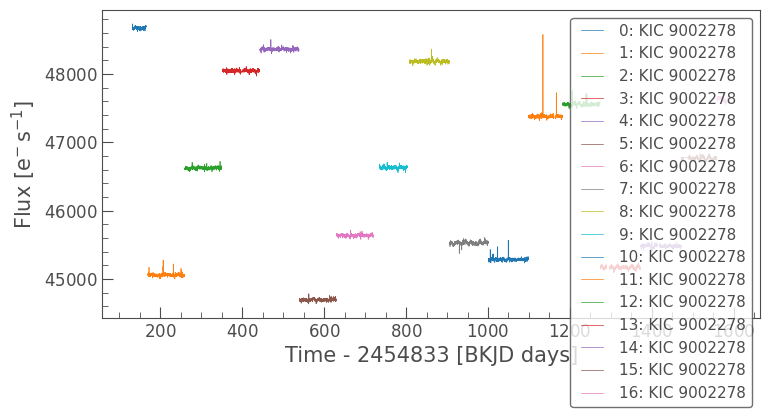

In [7]:
lc_coll.plot()

We have now collected several light curves for the Kepler-62 system from different exposures, let us move on to the next section wherein they are processed.

### Data Cleaning

Applying a CBVCorrector can account for irrelevant trends in the star's flux.

In [8]:
for lc in lc_coll:
    cbvCorrector = CBVCorrector(lc)
    lc = cbvCorrector.corrected_lc

In [9]:
lc_stitched = lc_coll.stitch()
lc_stitched

time,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,int32,float32,float64,float64,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
131.512759519479,1.0001726e+00,1.4223128e-04,0,1.765699e-03,292.99608,229.44654,1105,4.6141078e+04,6.5489445e+00,1.4994385e+03,5.6851053e-01,4.8679277e+04,6.9225211e+00,0,———,———,———,———,292.99608,1.6148506e-04,229.44654,1.3491639e-04,3.7130363e-02,2.9931735e-02
131.53319390667457,9.9993950e-01,1.4224710e-04,0,1.766387e-03,292.99595,229.44659,1106,4.6130906e+04,6.5482755e+00,1.4986940e+03,5.6759667e-01,4.8667934e+04,6.9232912e+00,0,———,———,———,———,292.99595,1.6151588e-04,229.44659,1.3493947e-04,3.6987502e-02,3.0007223e-02
131.55362819364382,9.9977374e-01,1.4222717e-04,10000000,1.767074e-03,292.99606,229.44633,1107,4.6123086e+04,6.5481563e+00,1.4978459e+03,5.6786931e-01,4.8659867e+04,6.9223218e+00,10000000,———,———,———,———,292.99606,1.6153303e-04,229.44633,1.3496721e-04,3.7085284e-02,2.9832473e-02
131.57406238060503,9.9993283e-01,1.4216275e-04,0,1.767761e-03,292.99570,229.44590,1108,4.6128289e+04,6.5482516e+00,1.4967012e+03,5.6815886e-01,4.8667609e+04,6.9191861e+00,0,———,———,———,———,292.99570,1.6152751e-04,229.44590,1.3495322e-04,3.7023611e-02,2.9454222e-02
131.59449666734145,9.9966550e-01,1.4225987e-04,0,1.768447e-03,292.99526,229.44618,1109,4.6116410e+04,6.5476556e+00,1.4990571e+03,5.6665975e-01,4.8654598e+04,6.9239130e+00,0,———,———,———,———,292.99526,1.6155574e-04,229.44618,1.3496407e-04,3.6280856e-02,2.9957959e-02
131.61493105407862,9.9983275e-01,1.4227608e-04,0,1.769134e-03,292.99497,229.44621,1110,4.6124887e+04,6.5480862e+00,1.4992825e+03,5.6858271e-01,4.8662738e+04,6.9247017e+00,0,———,———,———,———,292.99497,1.6153025e-04,229.44621,1.3495515e-04,3.6308520e-02,2.9853923e-02
131.63536524069787,9.9994051e-01,1.4224583e-04,0,1.769821e-03,292.99521,229.44613,1111,4.6127465e+04,6.5481815e+00,1.4973678e+03,5.6770813e-01,4.8667984e+04,6.9232292e+00,0,———,———,———,———,292.99521,1.6154032e-04,229.44613,1.3495761e-04,3.6200866e-02,2.9661760e-02
131.65579952707776,9.9972504e-01,1.4223128e-04,0,1.770507e-03,292.99479,229.44639,1112,4.6118293e+04,6.5477691e+00,1.4975309e+03,5.6824023e-01,4.8657496e+04,6.9225211e+00,0,———,———,———,———,292.99479,1.6154142e-04,229.44639,1.3496088e-04,3.6009379e-02,2.9989483e-02


<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

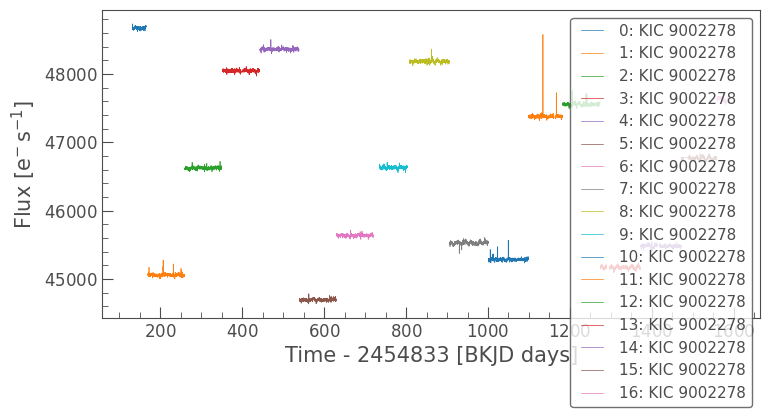

In [10]:
lc_coll.plot()

Below is the stitched light curve after the preprocessing steps.

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

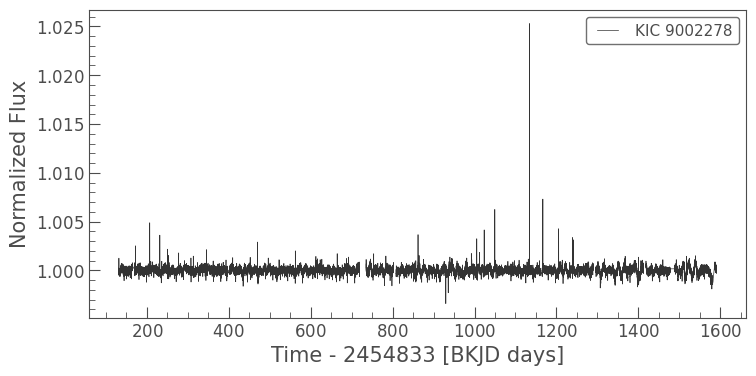

In [11]:
lc_stitched.plot()

It is now time to get the underlying patterns in the star's luminosity using the box-fitting least squares (BLS) algorithm. It is essentially a variant of the discrete Fourier transform that allows the signal to be decomposed into periodic box-shaped functions that may show the underlying dips in the star's luminosity as an exoplanet transits it.

<Axes: xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

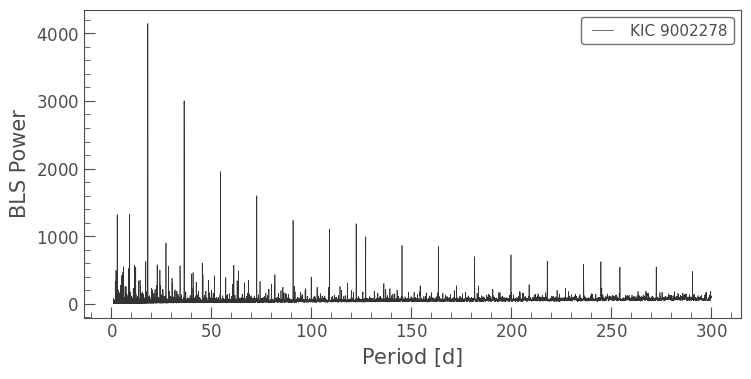

In [12]:
cp.cuda.Device(0).use
period = cp.linspace(1, 300, 80000).get()
bls = lc_stitched.remove_outliers(sigma=20, sigma_upper=5).flatten(300).to_periodogram(method='bls', period=period, frequency_factor=500)
bls.plot()

In [13]:
bls_period = bls.period_at_max_power
bls_t0 = bls.transit_time_at_max_power
bls_dur = bls.duration_at_max_power

bls_period

<Quantity 18.16281454 d>

The period with the highest power in the periodogram is remarkably close to Kepler-62d's orbital period, which shows that applying BLS was not only able to detect an exoplanet, but also returned a result that is highly accurate in terms of the signal period.

,flux,flux_err,time_original,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
time,,,,,,,,,,,,,,,,,,,
-9.081185,0.999844,0.000143,2009-05-16 22:57:28.016259098,0.001896,292.987489,229.442744,1298,46085.667969,6.545923,1484.401367,0.567962,48663.265625,6.939714,292.987489,0.000162,229.442744,0.000135,0.029077,0.026207
-9.081033,1.000076,0.000141,2011-04-25 07:21:21.014345633,0.000699,293.022929,229.460419,35964,43735.367188,6.145601,1179.334717,0.393775,48189.234375,6.816775,293.022929,0.000162,229.460419,0.000135,0.005829,-0.000880
-9.080942,1.000134,0.000147,2013-04-02 15:45:08.710133052,-0.000552,289.512789,231.351312,70630,40886.242188,6.012343,1336.340088,0.396529,46772.636719,6.873095,289.512789,0.000170,231.351312,0.000177,0.079262,0.066781
-9.080823,1.000304,0.000145,2010-12-19 04:00:28.942268877,-0.000952,289.979580,236.629186,29742,40835.488281,5.907573,1135.493530,0.331637,45652.988281,6.606636,289.979580,0.000166,236.629186,0.000139,0.070634,0.055144
-9.080744,0.999677,0.000161,2011-08-30 10:42:56.189097343,0.002835,293.355864,234.698135,42186,44525.257812,7.167043,1989.155518,0.911497,45515.136719,7.315864,293.355864,0.000196,234.698135,0.000194,-0.033131,-0.029798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.079859,1.000039,0.000145,2010-12-01 00:02:57.497711428,-0.000424,289.941809,236.602126,28853,40855.269531,5.902145,1037.163940,0.329317,45640.910156,6.605022,289.941809,0.000167,236.602126,0.000139,0.038511,0.030701
9.079880,1.000417,0.000141,2012-05-28 21:16:34.600328431,0.001699,292.987202,229.439541,55519,41850.085938,5.934696,924.696411,0.336005,47574.875000,6.723163,292.987202,0.000164,229.439541,0.000137,-0.024402,-0.010262
9.080469,1.000178,0.000147,2010-03-03 13:27:02.612113087,-0.000848,289.576647,231.377269,15520,45273.992188,6.707991,2396.882324,0.680765,48055.093750,7.078252,289.576647,0.000204,231.377269,0.000187,0.069424,0.058714


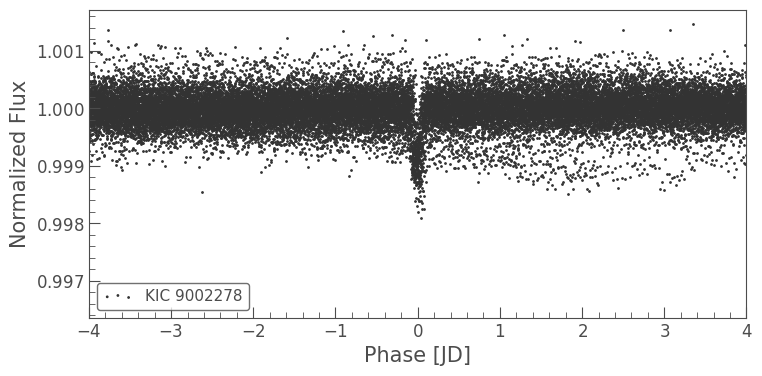

In [14]:
transit_candidate = lc_stitched.remove_outliers(sigma=20, sigma_upper=5).fold(period=bls_period, epoch_time=bls_t0)
tc_plot = transit_candidate.scatter()
tc_plot.set_xlim(-4,4)
tc_data = transit_candidate.to_pandas().dropna(axis=1).drop(['quality', 'sap_quality'], axis=1)
tc_data

The above folder time series data graph shows Kepler-62 star's dip in luminosity as the exoplanet Kepler-62d transits it.

### Data Preprocessing

In [15]:
def download_lc(index):
    max_ret = 5
    ret = 0
    while ret < max_ret:
        try:
            search_res = lk.search_lightcurve(f"KIC{index}", author="Kepler", cadence="long")
            lc_coll = search_res.download_all()
            return index, lc_coll
        except Exception as e:
            print(f"Error for KIC{index}: {e} Retrying.")
            time.sleep(6)
            ret += 1
    return index, None

In [16]:
def s_download_sample_lcs(kepids):
    results = {}

    for kepid in tqdm(kepids, desc="Downloading light curves"):
        index, lc_coll = download_lc(kepid)
        if lc_coll is not None:
            results[index] = lc_coll

    return results

In [17]:
def process_lc_coll(index, lc_coll):
    try:
        for lc in lc_coll:
            cbvCorrector = CBVCorrector(lc, interpolate_cbvs=True, extrapolate_cbvs=True)
            lc = cbvCorrector.corrected_lc

        lc_stitched = lc_coll.stitch()

        period = cp.linspace(1, 300, 80000).get()
        bls = lc_stitched.remove_outliers(sigma=20, sigma_upper=5).flatten(300).to_periodogram(method='bls', period=period, frequency_factor=500)

        bls_period = bls.period_at_max_power
        bls_t0 = bls.transit_time_at_max_power

        transit_candidate = lc_stitched.remove_outliers(sigma=20, sigma_upper=5).fold(period=bls_period, epoch_time=bls_t0)
        light_curve = transit_candidate.to_pandas().dropna(axis=1).drop(['quality', 'sap_quality'], axis=1)
        light_curve.reset_index(inplace=True)
        light_curve['kepid'] = index
        light_curve['koi_disposition'] = koi_objects.loc[koi_objects['kepid'] == index, 'koi_disposition'].values[0]
        
        return light_curve
    except Exception as e:
        logging.error(f"Error processing light curve collection for index {index}: {e}")
        return None

In [18]:
def process_sample_lcs(lc_colls):
    processed_lcs = []

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = {executor.submit(process_lc_coll, index, lc_coll): index for index, lc_coll in lc_colls.items()}

        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing light curves"):
            index = futures[future]
            try:
                lc = future.result()
                if lc is not None:
                    processed_lcs.append(lc)
            except Exception as e:
                print(f"Error processing light curve collection for KIC{index}: {e}")

    if processed_lcs:
        lc_df = pd.concat(processed_lcs)
        return lc_df
    else:
        return pd.DataFrame()

In [19]:
if not os.path.exists('train.csv'):
    lc_colls = s_download_sample_lcs(koi_objects['kepid'].values)
    lc_df = process_sample_lcs(lc_colls)
    lc_df.to_csv('train.csv')
else:
    lc_df = pd.read_csv('train.csv')

In [20]:
lc_df = lc_df.set_index('kepid').dropna(axis=1).sort_values(by=['kepid', 'time'])

In [21]:
lc_df

,Unnamed: 0,time,flux,flux_err,time_original,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,...,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2,koi_disposition
kepid,,,,,,,,,,,,,,,,,,,,,
2437060,0,-1.593082,1.011825,0.002114,2010-11-15 03:01:16.656179340,0.000320,100.837044,830.069153,28076,3613.0627,...,0.478945,2372.3003,4.956723,100.837044,0.000672,830.069153,0.000654,0.003855,-0.014105,FALSE POSITIVE
2437060,1,-1.593053,0.982001,0.001168,2010-04-09 06:14:10.477698119,-0.000196,97.013028,835.829605,17316,1352.1587,...,0.066297,2510.0588,2.984563,97.013028,0.000727,835.829605,0.000751,0.001051,-0.024065,FALSE POSITIVE
2437060,2,-1.593033,1.017627,0.001184,2011-04-29 19:43:50.072174245,0.000486,96.994461,835.833756,36185,1369.1036,...,0.064792,2601.7285,3.027587,96.994461,0.000719,835.833756,0.000740,0.001541,-0.009030,FALSE POSITIVE
2437060,3,-1.592525,0.972955,0.001713,2009-12-25 02:34:07.501224722,-0.001705,96.898357,829.293312,12170,1676.1959,...,0.154789,2158.0203,3.800270,96.898357,0.000716,829.293312,0.000995,-0.103431,0.155257,FALSE POSITIVE
2437060,4,-1.592391,1.026444,0.001698,2011-01-17 20:32:27.638647165,-0.002086,96.930162,829.286269,31195,1746.3456,...,0.150109,2303.3315,3.809467,96.930162,0.000711,829.286269,0.000993,-0.061437,0.098987,FALSE POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12735830,64743,15.910763,1.000025,0.000266,2010-09-21 10:14:56.610782901,0.002235,437.100504,373.483314,25399,17408.0300,...,0.305537,23458.5400,6.243425,437.100504,0.000390,373.483314,0.000321,-0.058192,-0.138895,CONFIRMED
12735830,64744,15.911017,0.999864,0.000313,2010-02-10 15:16:16.362406835,-0.000989,442.083917,368.036622,14496,14302.0910,...,0.265358,23391.5920,7.318700,442.083917,0.000454,368.036622,0.000377,0.015638,0.035983,CONFIRMED
12735830,64745,15.911631,0.999649,0.000257,2012-11-25 02:38:27.926176954,0.000929,436.072369,365.818033,64339,17085.1840,...,0.218869,23996.1950,6.169194,436.072369,0.000354,365.818033,0.000286,0.002864,0.001585,CONFIRMED


In [22]:
label_col = 'koi_disposition'

In [23]:
lc_df[label_col] = lc_df[label_col].apply(lambda x: 1 if x == 'CONFIRMED' else 0)

In [24]:
def preprocess_data(df, scaler=None, new_length=25000):
    if scaler is None:
        scaler = MinMaxScaler()

    grouped_data = df.groupby('kepid')
    sequences = []
    labels = []

    def resample_sequence(time, flux, new_length=24999):
        # Ensure time and flux are NumPy arrays
        time = np.asarray(time)
        flux = np.asarray(flux)
        
        # Convert to CuPy arrays
        time = cp.asarray(time)
        flux = cp.asarray(flux)
        
        # Create new time indices for interpolation
        new_time_indices = cp.linspace(0, len(time) - 1, new_length)
        
        # Interpolate flux values based on new time indices
        resampled_flux = cp.interp(new_time_indices, cp.arange(len(time)), flux)
        
        return resampled_flux

    for kepid, group in grouped_data:
        group['time'] = scaler.fit_transform(group[['time']])
        time = group['time'].values
        flux = group['flux'].values
        sequence = resample_sequence(time, flux)
        label = group[label_col].iloc[0]
    
        sequences.append(torch.tensor(sequence, dtype=torch.float32))
        labels.append(torch.tensor(label, dtype=torch.float32))
    
    sequences = torch.stack(sequences)
    labels = torch.tensor(labels, dtype=torch.float32)

    return sequences, labels

In [25]:
train_df, test_df = train_test_split(lc_df, test_size=0.2)

In [26]:
x_train, y_train = preprocess_data(train_df)

In [27]:
x_test, y_test = preprocess_data(test_df)

### Model

In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [73]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, 512)
        self.pool1 = nn.MaxPool1d(128)
        self.conv2 = nn.Conv1d(16, 32, 128)
        self.pool2 = nn.MaxPool1d(32)

        self.fc1 = nn.Linear(32 * 2, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8,1)

        self.af = nn.Softmax(1)

    def forward(self, out):
        out = self.pool1(F.relu(self.conv1(out)))
        out = self.pool2(F.relu(self.conv2(out)))
        out = torch.flatten(out, 1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [74]:
learning_rate=0.0001

In [75]:
train_dataset = TensorDataset(x_train.unsqueeze(1), y_train.float())  # Add a channel dimension
test_dataset = TensorDataset(x_test.unsqueeze(1), y_test.float())

In [76]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [77]:
model = CNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [78]:
num_epochs = 800

In [83]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs,labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.unsqueeze(1).to(device)
        optimizer.zero_grad()

        # Forward
        outputs = model(inputs)
        # Backward
        loss = criterion(outputs, labels)
        loss.backward()
        # optimize
        optimizer.step()

        # stats
        running_loss += loss.item()

        predicted = (outputs > 0.5).float()  # Assuming binary classification with BCE loss
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy}%')
print("Training complete")

Epoch [1/800], Loss: 0.6385872789791652, Accuracy: 67.33668341708542%
Epoch [2/800], Loss: 0.6279867717197963, Accuracy: 67.33668341708542%
Epoch [3/800], Loss: 0.6061401409762246, Accuracy: 67.33668341708542%
Epoch [4/800], Loss: 0.6405911360468183, Accuracy: 67.33668341708542%
Epoch [5/800], Loss: 0.6532955510275704, Accuracy: 67.33668341708542%
Epoch [6/800], Loss: 0.64998345715659, Accuracy: 67.33668341708542%
Epoch [7/800], Loss: 0.6492579068456378, Accuracy: 67.33668341708542%
Epoch [8/800], Loss: 0.6231270602771214, Accuracy: 67.33668341708542%
Epoch [9/800], Loss: 0.6287322981016976, Accuracy: 67.33668341708542%
Epoch [10/800], Loss: 0.6146781061376844, Accuracy: 67.33668341708542%
Epoch [11/800], Loss: 0.6418664966310773, Accuracy: 67.33668341708542%
Epoch [12/800], Loss: 0.6289237099034446, Accuracy: 67.33668341708542%
Epoch [13/800], Loss: 0.6278616530554635, Accuracy: 67.33668341708542%
Epoch [14/800], Loss: 0.6391052092824664, Accuracy: 67.33668341708542%
Epoch [15/800], L

In [84]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test accuracy: {accuracy: .4f}%')

Test accuracy:  67.3367%
